# 수어 번역 AI 모델링

- 데이터 출처 : https://www.kaggle.com/datasets/datamunge/sign-language-mnist?select=sign_mnist_train

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random as rd
import cv2
import joblib

from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import mlflow
import mlflow.keras
np.set_printoptions(linewidth=np.inf)

In [2]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.figure(figsize=(10,6))
    plt.plot(history['loss'], label='train_err')
    plt.plot(history['val_loss'], label='val_err')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

In [3]:
path = ''
file = 'sign_language.csv'

data = pd.read_csv(path+file)
data.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,22,186,186,185,185,185,184,185,184,184,...,171,122,65,62,215,180,99,47,31,25
1,24,175,177,179,181,181,182,182,182,183,...,202,202,201,200,199,197,195,193,191,189
2,6,187,187,187,187,187,186,187,186,186,...,45,23,25,34,41,43,39,40,43,35
3,2,169,169,169,170,169,170,169,169,169,...,204,203,200,199,198,196,194,193,191,190
4,21,153,165,170,179,190,198,203,206,213,...,161,122,132,96,75,63,37,43,70,66


In [4]:
data.shape

(8000, 785)

## 전처리

In [5]:
## 학습데이터 전처리
import string
class_names = list(string.ascii_lowercase)
class_names = np.array(class_names)
len(class_names), class_names

# x:y나누기
target = 'label'
x = data.drop(target, axis = 1)
y = data.loc[:, target]

# train, val, test 분할
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 1000, random_state = 20)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 2000, random_state = 20)

# 모두 넘파이로 변환
x_train, x_val, y_train, y_val = x_train.values, x_val.values, y_train.values, y_val.values

# shape 맞추기
x_train = x_train.reshape(-1,28,28,1)
x_val = x_val.reshape(-1,28,28,1)

#스케일링 min max
x_train_s = x_train / 255.
x_val_s = x_val / 255.

## 모델링
- mlflow : 훈련과정에서의 정보를 기록
- 로컬 mlflow 서버 실행 : mlflow server --backend-store-uri sqlite:///mlflow.db --default-artifact-root ./artifacts

In [6]:
# 추적준비
mlflow_uri = 'sqlite:///mlflow.db' #개인용 mlflowdb에서 추적
mlflow.set_tracking_uri(mlflow_uri)

In [7]:
#새 실험 생성
exp_id = mlflow.create_experiment('exp_sign_lang')
exp_id

2023/05/20 13:47:05 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2023/05/20 13:47:06 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Running upgrade  -> 451aebb31d03, add metric step
INFO  [alembic.runtime.migration] Running upgrade 451aebb31d03 -> 90e64c465722, migrate user column to tags
INFO  [alembic.runtime.migration] Running upgrade 90e64c465722 -> 181f10493468, allow nulls for metric values
INFO  [alembic.runtime.migration] Running upgrade 181f10493468 -> df50e92ffc5e, Add Experiment Tags Table
INFO  [alembic.runtime.migration] Running upgrade df50e92ffc5e -> 7ac759974ad8, Update run tags with larger limit
INFO  [alembic.runtime.migration] Running upgrade 7ac759974ad8 -> 89d4b8295536, create latest metrics table
INFO  [89d4b8295536_create_latest_metrics_table_py] Migration complete!
INFO  

'1'

In [9]:
#모델학습
from keras.models import Sequential
from keras.layers import Input,Dense, Flatten, Conv2D, MaxPooling2D
from keras.backend import clear_session
from keras.optimizers import Adam

In [10]:
INPUT_SIZE = x_train.shape[1]
CH = x_train.shape[-1]
# OUTPUT_SIZE = data['label'].nunique()
OUTPUT_SIZE = len(class_names)
INPUT_SIZE,CH, OUTPUT_SIZE

(28, 1, 26)

In [15]:
from keras.callbacks import EarlyStopping
# 얼리스토핑 적용시  val_loss, val_acc 등 자동 기록 
with mlflow.start_run(experiment_id= exp_id, run_name = 'base_CNN'):
    
    #오토로그 시작
    mlflow.keras.autolog()
    #1. backend session clear
    clear_session() #이게 필요할까?

    #2. model선언, 설계
    model = Sequential([Input(shape = (INPUT_SIZE, INPUT_SIZE,CH)),
                        Conv2D(64, (3, 3),padding='same', activation='relu'),
                        MaxPooling2D((2, 2)),
                        Flatten(),
                        Dense(OUTPUT_SIZE, activation='softmax')])


    #3. 모델 컴파일
    model.compile(loss = "sparse_categorical_crossentropy", metrics = ['accuracy'], optimizer = 'adam') 
    
    es = EarlyStopping(monitor = 'val_loss',
                       min_delta = 0,
                       patience = 3,
                       verbose=1,
                       restore_best_weights = True)
    # 학습
    history = model.fit(x_train_s, y_train, epochs = 30, validation_split = .2, callbacks = [es]).history
    
    # 모델 등록
    mlflow.keras.log_model(model, 'cnn-model', registered_model_name = "Sign_Signal")
    
    #오토로그 종료
    mlflow.keras.autolog(disable=True)
    

Epoch 1/30
125/125 [==============================] - 4s 26ms/step - loss: 2.6480 - accuracy: 0.2743 - val_loss: 1.7580 - val_accuracy: 0.6010
Epoch 2/30
125/125 [==============================] - 3s 21ms/step - loss: 1.2759 - accuracy: 0.6705 - val_loss: 0.9411 - val_accuracy: 0.7670
Epoch 3/30
125/125 [==============================] - 3s 22ms/step - loss: 0.7482 - accuracy: 0.8158 - val_loss: 0.6771 - val_accuracy: 0.8370
Epoch 4/30
125/125 [==============================] - 3s 22ms/step - loss: 0.4893 - accuracy: 0.8910 - val_loss: 0.4758 - val_accuracy: 0.9060
Epoch 5/30
125/125 [==============================] - 3s 28ms/step - loss: 0.3416 - accuracy: 0.9315 - val_loss: 0.3641 - val_accuracy: 0.9130
Epoch 6/30
125/125 [==============================] - 4s 29ms/step - loss: 0.2522 - accuracy: 0.9505 - val_loss: 0.2788 - val_accuracy: 0.9410
Epoch 7/30
125/125 [==============================] - 4s 30ms/step - loss: 0.1884 - accuracy: 0.9647 - val_loss: 0.2654 - val_accuracy: 0.9310

WARNI [absl] Found untraced functions such as _jit_compiled_convolution_op, _update_step_xla while saving (showing 2 of 2). These functions will not be directly callable after loading.
2023/05/20 13:58:43 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
WARNI [absl] Found untraced functions such as _jit_compiled_convolution_op, _update_step_xla while saving (showing 2 of 2). These functions will not be directly callable after loading.
Registered model 'Sign_Signal' already exists. Creating a new version of this model...
2023/05/20 13:59:02 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: Sign_Signal, version 2
Created version '2' of model 'Sign_Signal'.


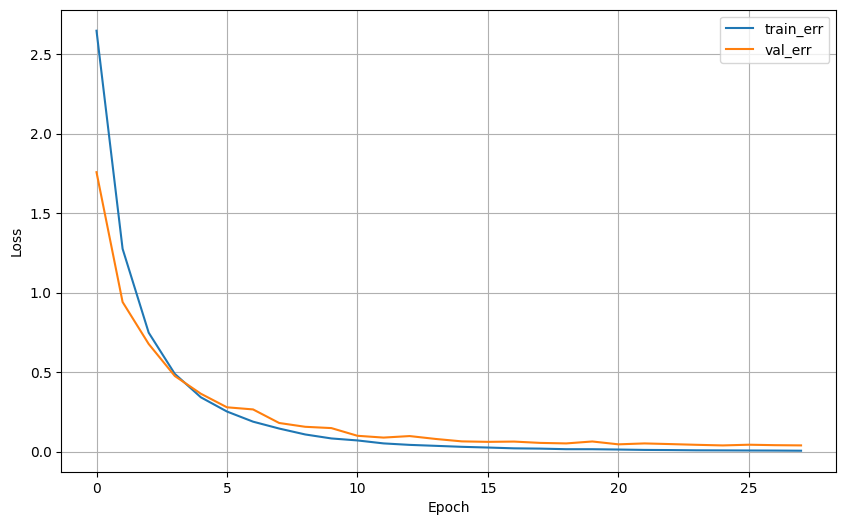

In [16]:
# 학습곡선
dl_history_plot(history) 


In [17]:
# val에대해 예측/성능평가
y_pred = model.predict(x_val_s)
y_pred0 = y_pred.argmax(axis=1)

print("실제:",y_pred0[:10])
print("예측:",y_val[:10])
print(accuracy_score(y_val, y_pred0))
print(f1_score(y_val, y_pred0, average = 'macro')) #multi class의 경우 average 를 설정해줘야한다.
print(classification_report(class_names[y_val], class_names[y_pred0]))

63/63 [==============================] - 1s 8ms/step
실제: [15  6 11 12 18 11 15  0 19 24]
예측: [15  6 11 12 18 11 15  0 19 24]
0.9925
0.9925604902399305
              precision    recall  f1-score   support

           a       1.00      1.00      1.00        77
           b       1.00      1.00      1.00        64
           c       1.00      1.00      1.00        69
           d       1.00      1.00      1.00        96
           e       1.00      0.94      0.97        69
           f       1.00      0.98      0.99       103
           g       1.00      1.00      1.00        80
           h       1.00      0.98      0.99        81
           i       0.99      1.00      0.99        85
           k       0.99      1.00      0.99        81
           l       1.00      1.00      1.00        86
           m       0.97      1.00      0.98        93
           n       1.00      1.00      1.00        71
           o       1.00      0.98      0.99        87
           p       1.00      1.00     

## 성능평가(test)

In [19]:
#모델 사용해서 성능평가
model_uri = 'models:/Sign_Signal/production'
model_prod = mlflow.keras.load_model(model_uri)

In [20]:
#  x_test 준비 -> 넘파이 변환/ reshape/ scailing
x_test = x_test.values
x_test = x_test.reshape(-1,28,28,1)
x_test_s = x_test/255.

In [28]:
type(y_test)
y_test = y_test.values

In [29]:
# val에대해 예측/성능평가
y_pred = model_prod.predict(x_test_s)
y_pred0 = y_pred.argmax(axis=1)

print("실제:",y_pred0[:10])
print("예측:",y_test[:10])
print(accuracy_score(y_test, y_pred0))
print(f1_score(y_test, y_pred0, average = 'macro')) #multi class의 경우 average 를 설정해줘야한다.
print(classification_report(class_names[y_test], class_names[y_pred0]))

32/32 [==============================] - 0s 7ms/step
실제: [15 10  6 17  2  0  6 17 16 23]
예측: [15 10  6 17  2  0  6 17 16 23]
0.991
0.9907562919108974
              precision    recall  f1-score   support

           a       1.00      1.00      1.00        46
           b       1.00      1.00      1.00        39
           c       1.00      1.00      1.00        43
           d       1.00      1.00      1.00        45
           e       1.00      0.93      0.96        40
           f       1.00      1.00      1.00        42
           g       1.00      1.00      1.00        45
           h       1.00      1.00      1.00        43
           i       1.00      1.00      1.00        42
           k       1.00      1.00      1.00        37
           l       1.00      1.00      1.00        39
           m       0.96      1.00      0.98        45
           n       1.00      1.00      1.00        42
           o       1.00      1.00      1.00        34
           p       1.00      1.00      

## 새로운 데이터에 대해 분류하기(운영 서비스)

In [ ]:
# 모델로 새로운 이미지 분류해보기 
# 파이프라인에서 필요한 라이브러리/함수
import pandas as pd
import numpy as np
import cv2
import joblib

# class names 준비
class_names = list(string.ascii_lowercase)
class_names = np.array(class_names)

# 파일 로딩
file = 'test_imgs/v.png'

# 흑백으로 읽기
img = cv2.imread(file , cv2.IMREAD_GRAYSCALE)

# 크기 조정
img = cv2.resize(img, (28, 28))

# input shape 맞추기
test_sign = img.reshape(1,28,28,1)

# 스케일링
test_sign = test_sign / 255.

# 모델 로딩
# model2 = joblib.load('model.pkl')

# 예측
pred = model_prod.predict(test_sign)
pred_1 = pred.argmax(axis=1)
print(class_names[pred_1])